<a href="https://colab.research.google.com/github/Karsten-Yan/ky_facs_ai/blob/master/facs_ai_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fcsparser
!pip install scikit-plot

In [2]:
!apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [3]:
import fcsparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier
import scikitplot as skplt
import matplotlib as mpl

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from umap import UMAP
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# some general parameters for plots
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams['axes.edgecolor'] = "grey"
mpl.rcParams['figure.edgecolor'] = "grey"
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['legend.edgecolor'] = "grey"
mpl.rcParams['legend.shadow'] = False
mpl.rcParams["legend.framealpha"] = 1
mpl.rcParams['font.weight'] = "bold"
mpl.rcParams['axes.labelweight'] = "bold"
mpl.rcParams['axes.titleweight'] = "bold"

# Data Import

In [5]:
!svn checkout https://github.com/Karsten-Yan/ky_facs_ai/trunk/data/shedding/export

Checked out revision 13.


In [6]:
path = "/content/export"

In [7]:
genotype = ["WT","KO","KO","WT","WT","KO","WT","KO","WT"]

In [8]:
gt_dict = {idx:elm for idx,elm in enumerate(genotype)}

In [9]:
anti =["CD8","CD62L","CD3","IL6Ra","TNFa","unused","CD4","PacO"]
antibodies = anti.copy()
#order = [7,8,9,10,11,0,1,2,3,4,5,6]
#antibodies = [antibodies[i] for i in order]
antibodies.insert(0,"SSC_W")
antibodies.insert(0,"SSC_H")
antibodies.insert(0,"SSC_A")
antibodies.insert(0,"FSC_W")
antibodies.insert(0,"FSC_H")
antibodies.insert(0,"FSC_A")
antibodies.insert(0,"genotype")
antibodies.insert(0,"mousenr")
antibodies.insert(0,"stim")
antibodies.insert(0,"pop")
antibodies.append("time")

In [10]:
def read_fcs_data(path_sub, gt_dict, antibodies):
    
    df = pd.DataFrame()

    for elm in os.listdir(path_sub):
        if elm.endswith(".fcs"):
          temp_df = pd.DataFrame()
          file = os.path.join(path_sub, elm)

          meta, data = fcsparser.parse(file, meta_data_only=False, reformat_meta=True)
          elm_split = elm.split("_")
          split_first = elm_split[0].split(" ")
          temp_df["pop"] = [split_first[-1]]*len(data)
          temp_df["stim"] = [split_first[1]]*len(data)

          int_list = list(elm_split[2])
          gt = int(int_list[2])
          temp_df["mousenr"] = [gt]*len(data)
          temp_df["genotype"]=[gt_dict[gt-1]]*len(data)

          temp_df = pd.concat([temp_df, data],axis=1)
          
          df = pd.concat([df, temp_df],axis=0)
    df["genotype"] = df["genotype"].astype("category")
    df["pop"] = df["pop"].astype("category")
    df["mousenr"] = df["mousenr"].astype("category")

    df.columns = antibodies
    df.reset_index(inplace=True)
    df.drop("time",inplace=True,axis=1)
    df.drop("index",inplace=True,axis=1)
    df.drop("unused",inplace=True,axis=1)
    df.drop("PacO",inplace=True,axis=1)   
    return df
    

In [11]:
df = read_fcs_data(path, gt_dict, antibodies)

In [12]:
numeric_features = list(df.columns[df.dtypes ==  "float32"])

In [13]:
gating_features = ["CD4","CD8"]

In [14]:
z = np.abs(stats.zscore(df[numeric_features]))
len(np.where(z > 11)[0])

12483

In [15]:
dfo = df[(z < 11).all(axis=1)].copy()

In [16]:
def facs_plot( stim,pop,mousenr,x,y,df=dfo):
    temp_df = df[(df["mousenr"]==mousenr)&(df["pop"]==pop)&(df["stim"]==stim)].sample(frac=0.1)
    ax = sns.scatterplot(data=temp_df, x=x,y=y)
    ax.set_xscale("symlog",linthreshx=100,linscalex=0.2)
    ax.set_yscale("symlog",linthreshy=100,linscaley=0.2)
    ax.set_xlim(-1000,300000)
    ax.set_ylim(-1000,300000)
    
    return ax

In [17]:
xtoggle = widgets.ToggleButtons(options=anti, description="Y Axis",value="CD4")
ytoggle = widgets.ToggleButtons(options=anti, description="X Axis",value="CD8")
poptoggle=widgets.ToggleButtons(options=list(df["pop"].unique()),description="pop",value="Without")
stimtoggle=widgets.ToggleButtons(options=list(df["stim"].unique()),description="stim",value="Unstimulated")
mousenr = widgets.BoundedIntText(min=1,max=np.max(df.mousenr.unique().as_ordered()), description = "mousenr")
out = widgets.interactive_output(facs_plot, {"mousenr":mousenr, "x":xtoggle, "y":ytoggle,"pop":poptoggle,"stim":stimtoggle})
display(mousenr,xtoggle,ytoggle,poptoggle,stimtoggle,out)

BoundedIntText(value=1, description='mousenr', max=1, min=1)

ToggleButtons(description='Y Axis', index=6, options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'unused', 'CD4',…

ToggleButtons(description='X Axis', options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'unused', 'CD4', 'PacO'),…

ToggleButtons(description='pop', index=2, options=('GI', 'GW', 'Without'), value='Without')

ToggleButtons(description='stim', options=('Unstimulated', 'stimulated'), value='Unstimulated')

Output()

# Gating

In [18]:
seed=42

In [19]:
gating=GaussianMixture(3,random_state=seed,covariance_type="full",max_iter=1000,tol = 10)
dfo["label"] = gating.fit_predict(dfo[gating_features])

In [20]:
def facs_plot2( stim,pop,mousenr,x,y,df=dfo):
    temp_df = df[(df["mousenr"]==mousenr)&(df["pop"]==pop)&(df["stim"]==stim)].sample(frac=0.01)
    ax = sns.scatterplot(data=temp_df, x=x,y=y,hue="label")
    ax.set_xscale("symlog",linthreshx=100,linscalex=0.2)
    ax.set_yscale("symlog",linthreshy=100,linscaley=0.2)
    ax.set_xlim(-1000,300000)
    ax.set_ylim(-1000,300000)
    
    return ax

In [21]:
xtoggle = widgets.ToggleButtons(options=anti, description="Y Axis",value="CD4")
ytoggle = widgets.ToggleButtons(options=anti, description="X Axis",value="CD8")
poptoggle=widgets.ToggleButtons(options=list(df["pop"].unique()),description="pop",value="Without")
stimtoggle=widgets.ToggleButtons(options=list(df["stim"].unique()),description="stim",value="Unstimulated")
mousenr = widgets.BoundedIntText(min=1,max=np.max(df.mousenr.unique().as_ordered()), description = "mousenr")
out = widgets.interactive_output(facs_plot2, {"mousenr":mousenr, "x":xtoggle, "y":ytoggle,"pop":poptoggle,"stim":stimtoggle})
display(mousenr,xtoggle,ytoggle,poptoggle,stimtoggle,out)

BoundedIntText(value=1, description='mousenr', max=1, min=1)

ToggleButtons(description='Y Axis', index=6, options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'unused', 'CD4',…

ToggleButtons(description='X Axis', options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'unused', 'CD4', 'PacO'),…

ToggleButtons(description='pop', index=2, options=('GI', 'GW', 'Without'), value='Without')

ToggleButtons(description='stim', options=('Unstimulated', 'stimulated'), value='Unstimulated')

Output()

In [22]:
map_dict={0:"rest",2:"CD4TCells",1:"CD8TCells"}
dfo.label=dfo.label.map(map_dict)

In [23]:
dfo["label2"] = dfo["pop"].astype("str")+"_"+dfo["stim"].astype("str")+"_"+dfo["genotype"].astype("str")
dfo["label2"] = dfo["label2"].astype("category")

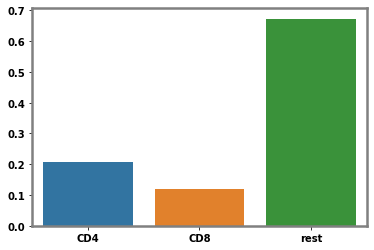

In [24]:
data = np.array(dfo.groupby("label").count()["pop"])
sns.barplot(y = data/np.sum(data),
           x=["CD4","CD8","rest"]);

# DRR analysis

In [25]:
df_unsup = pd.concat([dfo[(dfo["genotype"]=="WT")&(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")].sample(12500),
                      dfo[(dfo["genotype"]=="KO")&(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")].sample(12500)], axis=0)
df_unsup_unstim = pd.concat([dfo[(dfo["genotype"]=="WT")&(dfo["stim"] == "Unstimulated")&(dfo["pop"]=="Without")].sample(12500),
                      dfo[(dfo["genotype"]=="KO")&(dfo["stim"] == "Unstimulated")&(dfo["pop"]=="Without")].sample(12500)], axis=0)

In [26]:
drr_features = set(numeric_features).intersection( set(anti))

In [27]:
def drr_plot(df,name,hue):
    fig,ax = plt.subplots(1,3,figsize=(20,7))
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df,hue=hue, 
                    ax=ax[0], hue_norm=(0,1000), palette="viridis")
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df[df["genotype"]=="KO"],hue=hue, 
                    ax=ax[1], hue_norm=(0,1000), palette="viridis")
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df[df["genotype"]=="WT"],hue=hue, 
                    ax=ax[2], hue_norm=(0,1000), palette="viridis")

    ax[0].set_title("Both Genotypes")
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].get_legend().remove()
    ax[1].set_title("Knockout")
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].get_legend().remove()
    ax[2].set_title("Wildtype")
    ax[2].set_xlabel("")
    ax[2].set_ylabel("")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].get_legend().remove()
    plt.suptitle(name + " Analysis "+hue)

## UMAP

[Bokeh Visualisation (Heroku)](https://umap-bokeh.herokuapp.com/)

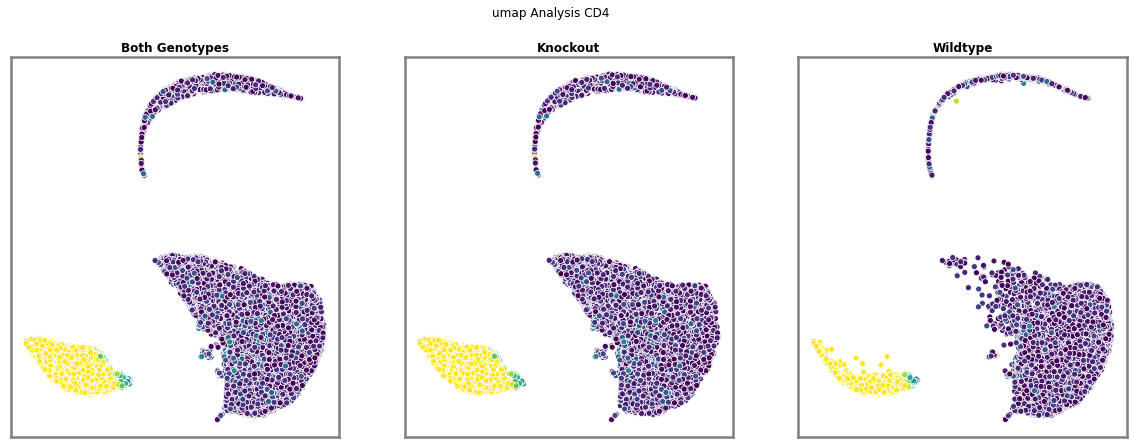

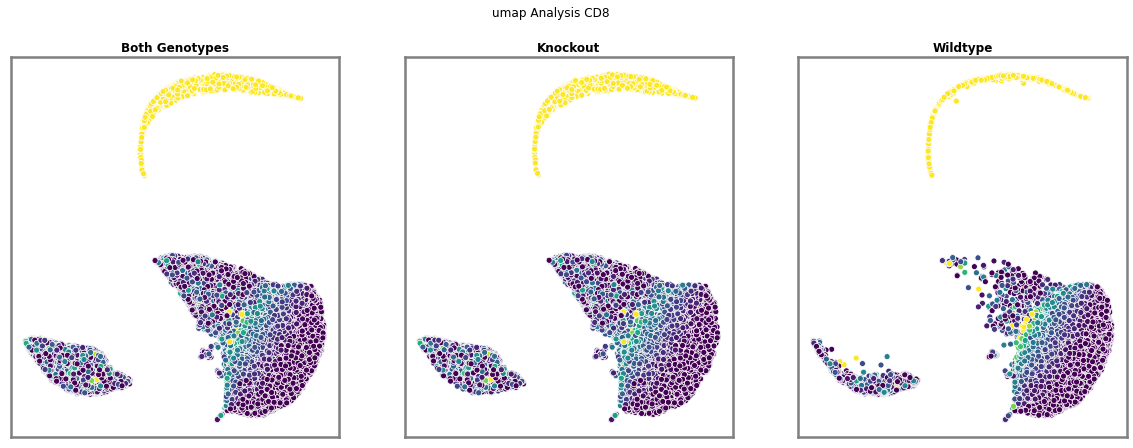

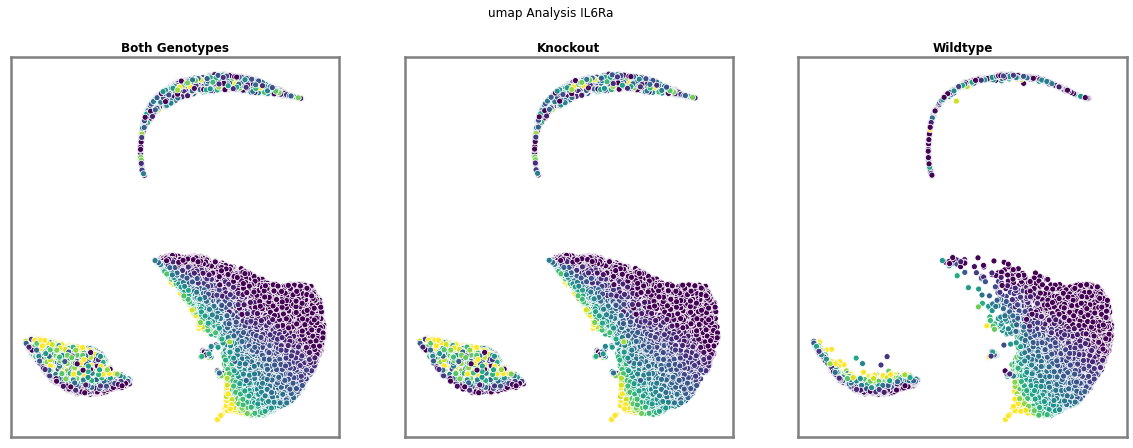

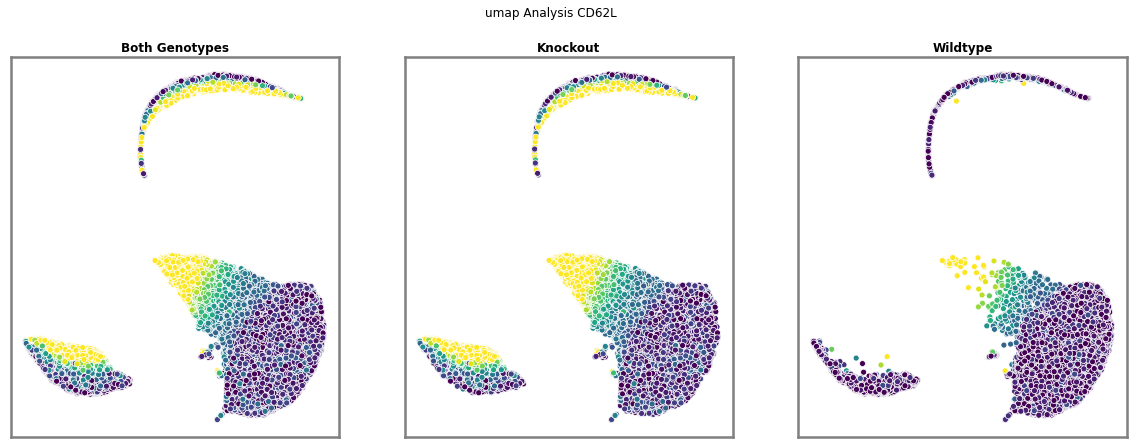

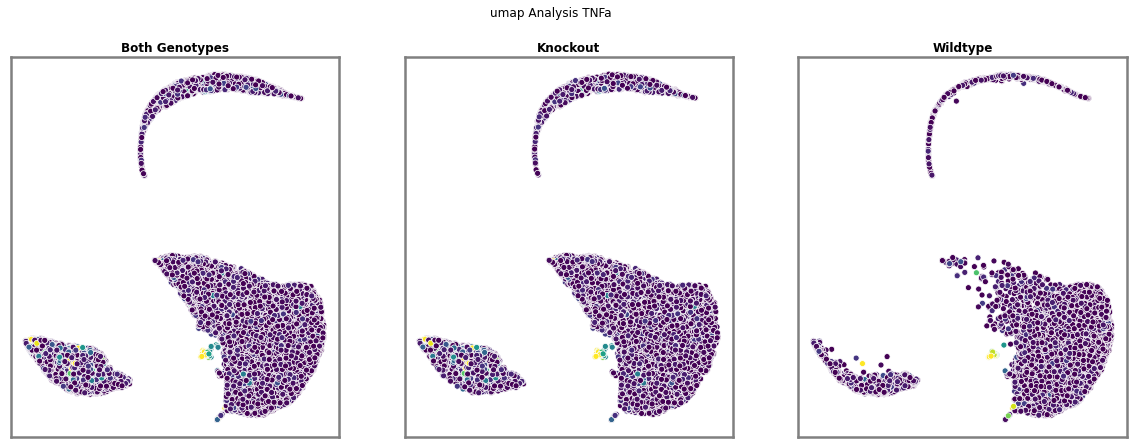

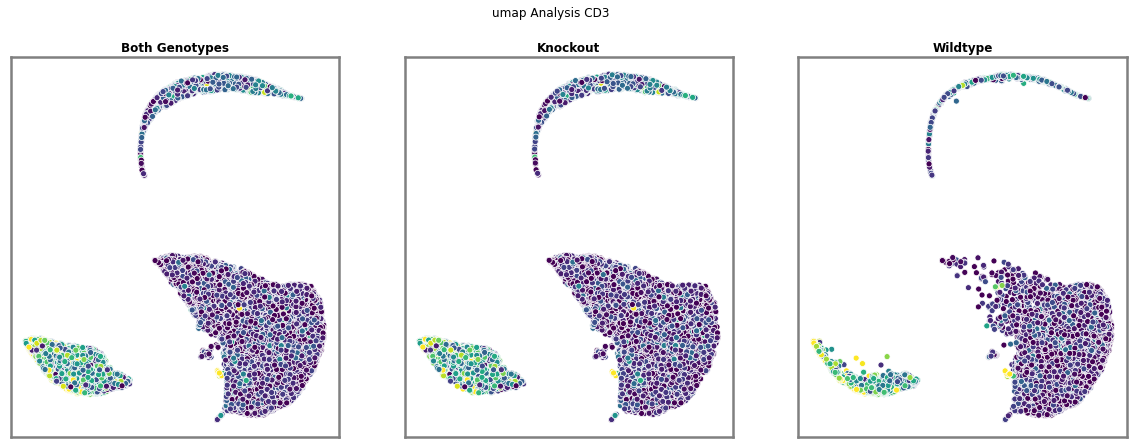

In [28]:
umap = UMAP(n_neighbors=40)
umap_dims = umap.fit_transform(df_unsup[drr_features])
umap_df = pd.DataFrame(umap_dims)
umap_df.columns = ["umap_dim_1","umap_dim_2"]
umap_df = pd.concat([umap_df, df_unsup.reset_index()],axis=1)

for elm in drr_features:
    drr_plot(umap_df,"umap",elm)

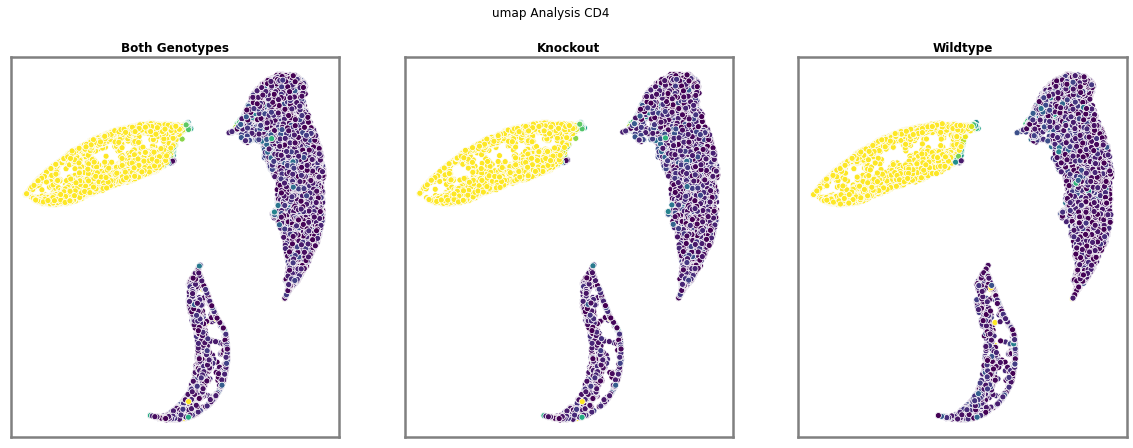

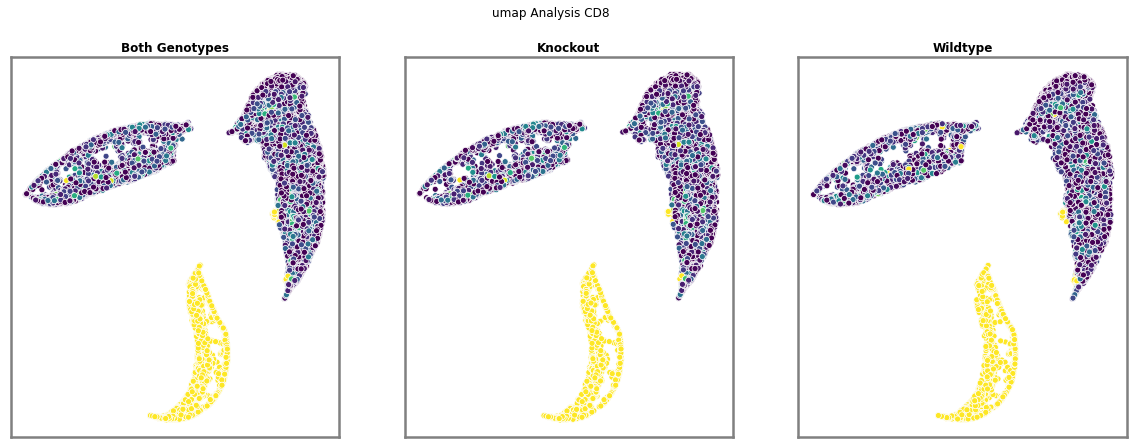

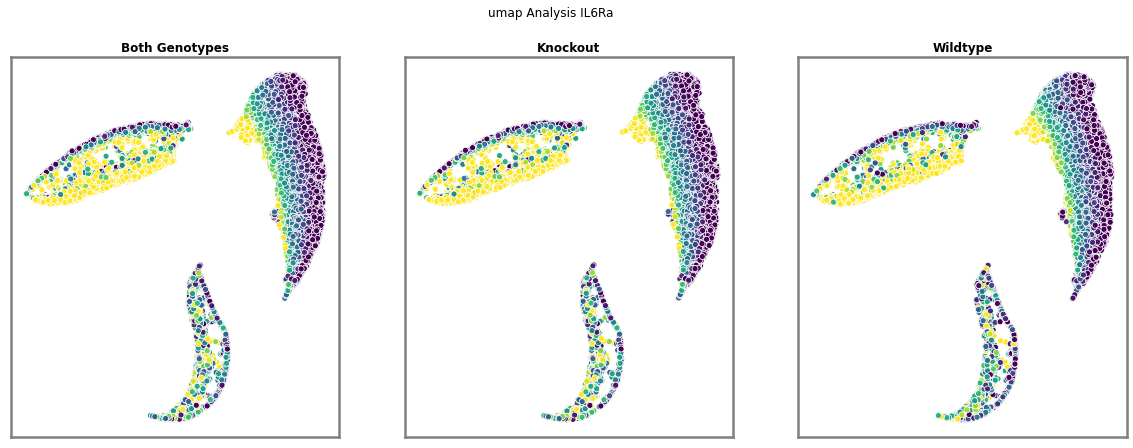

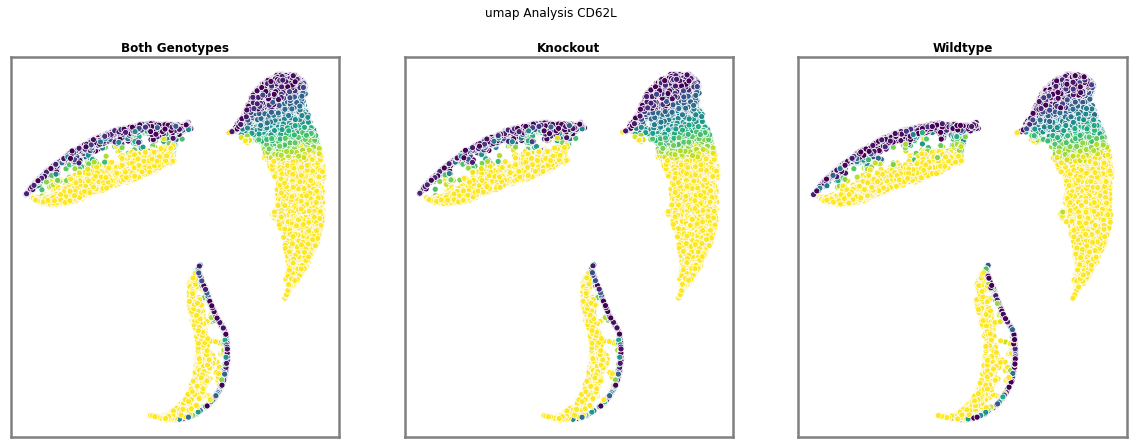

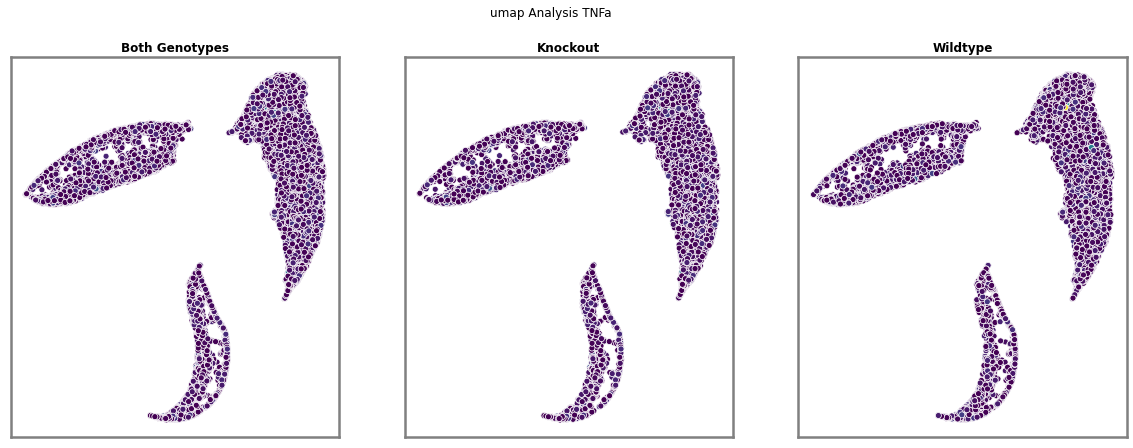

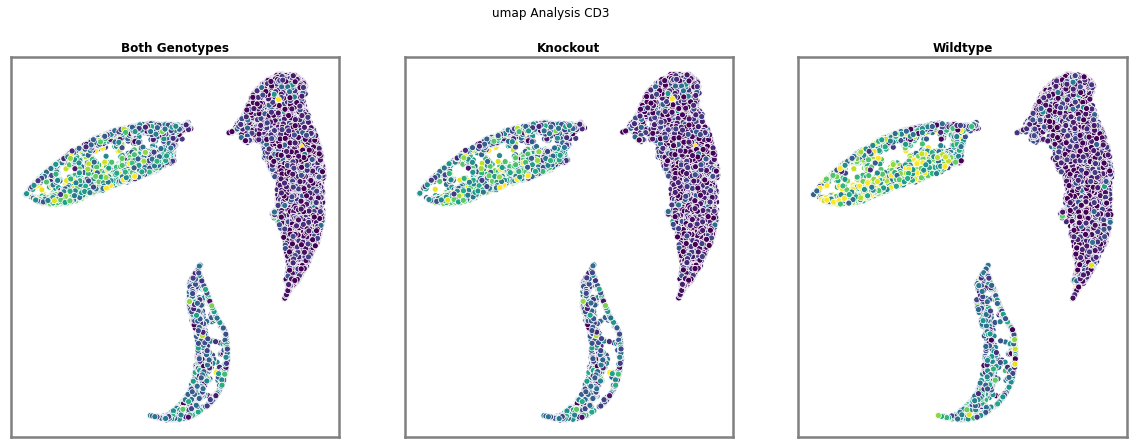

In [29]:
umap_unstim = UMAP(n_neighbors=40)
umap_dims_unstim = umap_unstim.fit_transform(df_unsup_unstim[drr_features])
umap_df_unstim = pd.DataFrame(umap_dims_unstim)
umap_df_unstim.columns = ["umap_dim_1","umap_dim_2"]
umap_df_unstim = pd.concat([umap_df_unstim, df_unsup_unstim.reset_index()],axis=1)

for elm in drr_features:
    drr_plot(umap_df_unstim,"umap",elm)

# predictive modelling

In [30]:
def pop_model(df,gt,pop,x_list, y_label, model, top=3):
    konr = df[df["genotype"]==gt[0]]["mousenr"].unique()
    wtnr = df[df["genotype"]==gt[1]]["mousenr"].unique()
    
    df_train = df[df["mousenr"].isin(konr[:-1])|df["mousenr"].isin(wtnr[:-1])]
    df_val = df[df["mousenr"].isin(konr[-1:])|df["mousenr"].isin(wtnr[-1:])]
  
    df_pop_train = df_train[df_train["label"] == pop]
    df_pop_val = df_val[df_val["label"] == pop]
    
    X_train = df_pop_train[x_list]
    y_train = df_pop_train[y_label]
    X_val = df_pop_val[x_list]
    y_val = df_pop_val[y_label]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    ax1=skplt.metrics.plot_confusion_matrix(y_val, y_pred, figsize=(10,10), text_fontsize=20, normalize = True)
    xlabels = ax1.get_xticklabels()
    ax1.set_xticklabels(xlabels,rotation=45)
    ax1.images[-1].colorbar.remove()
    
    skplt.estimators.plot_feature_importances(model, feature_names=x_list,max_num_features=20)
    plt.xticks(rotation=90)
    plt.show();
    
    fimp = sorted([(elm,numeric_features[idx]) for idx,elm in enumerate(model.feature_importances_)],reverse=True)
    
    fig, axs = plt.subplots(1,top,figsize=(9,3))
    for i in range(top):
        sns.barplot(x = df_pop_train.genotype.astype("object"), y = df_pop_train[fimp[i][1]], ax = axs[i] )
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_val, y_pred))

## CD8

### CD8 without

In [31]:
df_sup_wo = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")]

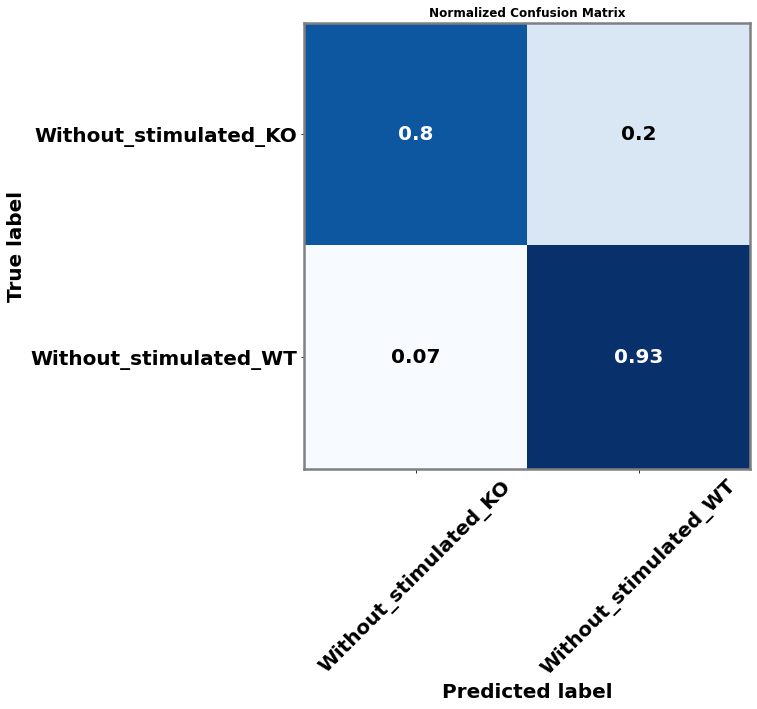

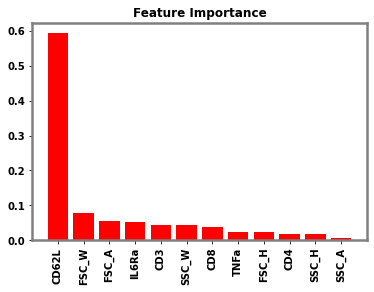

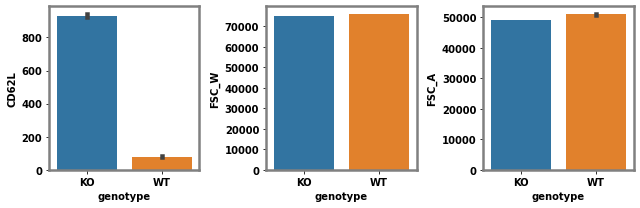

                       precision    recall  f1-score   support

Without_stimulated_KO       0.92      0.80      0.86     13211
Without_stimulated_WT       0.82      0.93      0.87     12656

             accuracy                           0.86     25867
            macro avg       0.87      0.86      0.86     25867
         weighted avg       0.87      0.86      0.86     25867



In [32]:
xgb_clf_cd8_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_wo,3)

### CD8 GI

In [33]:
df_sup_gi = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="GI")]

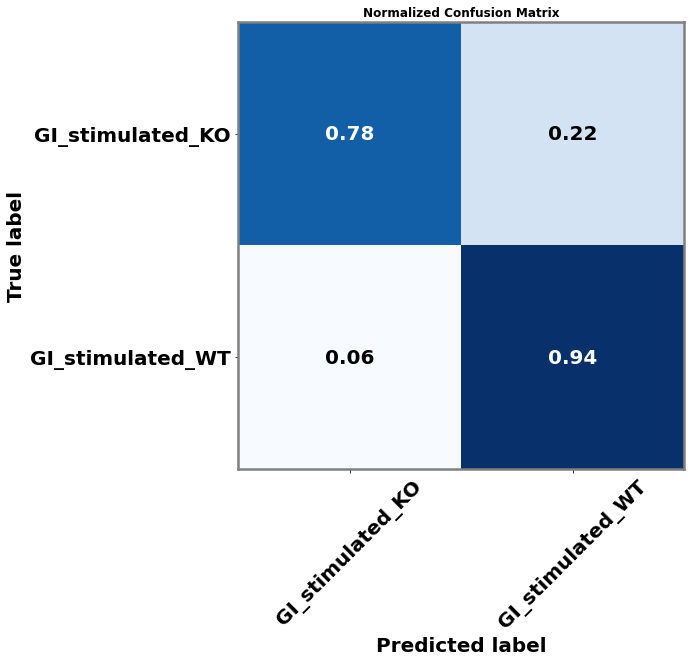

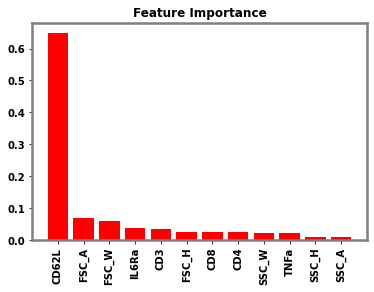

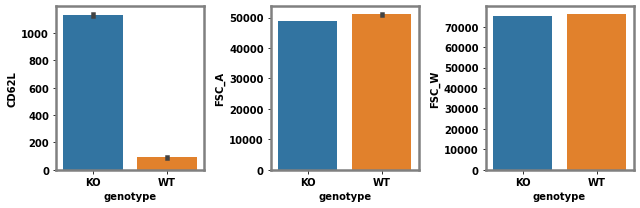

                  precision    recall  f1-score   support

GI_stimulated_KO       0.92      0.78      0.85     11618
GI_stimulated_WT       0.83      0.94      0.88     12723

        accuracy                           0.87     24341
       macro avg       0.88      0.86      0.86     24341
    weighted avg       0.87      0.87      0.87     24341



In [34]:
xgb_clf_cd8_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_gi,3)

### CD8 gw

In [35]:
df_sup_gw = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="GW")]

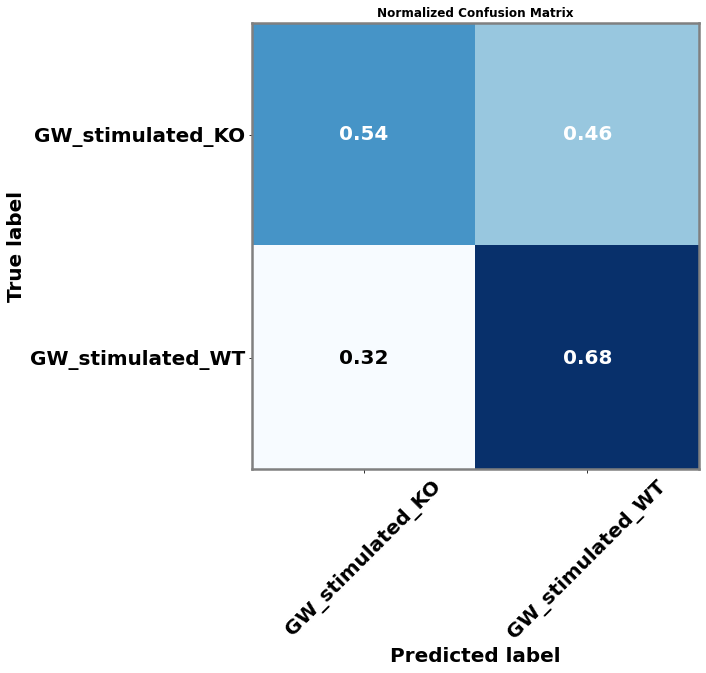

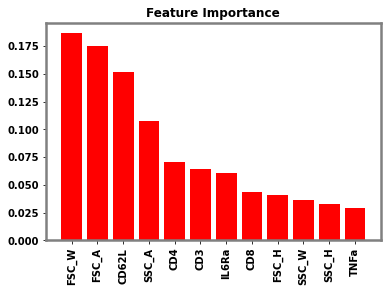

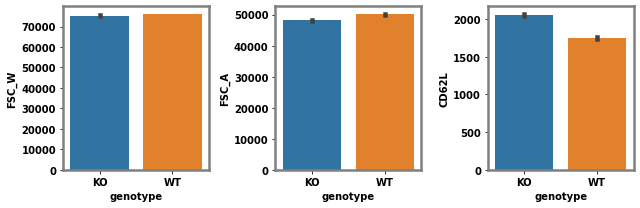

                  precision    recall  f1-score   support

GW_stimulated_KO       0.65      0.54      0.59     12657
GW_stimulated_WT       0.58      0.68      0.63     11675

        accuracy                           0.61     24332
       macro avg       0.61      0.61      0.61     24332
    weighted avg       0.61      0.61      0.61     24332



In [36]:
xgb_clf_cd8_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_gw,3)

## CD4

### CD4 without

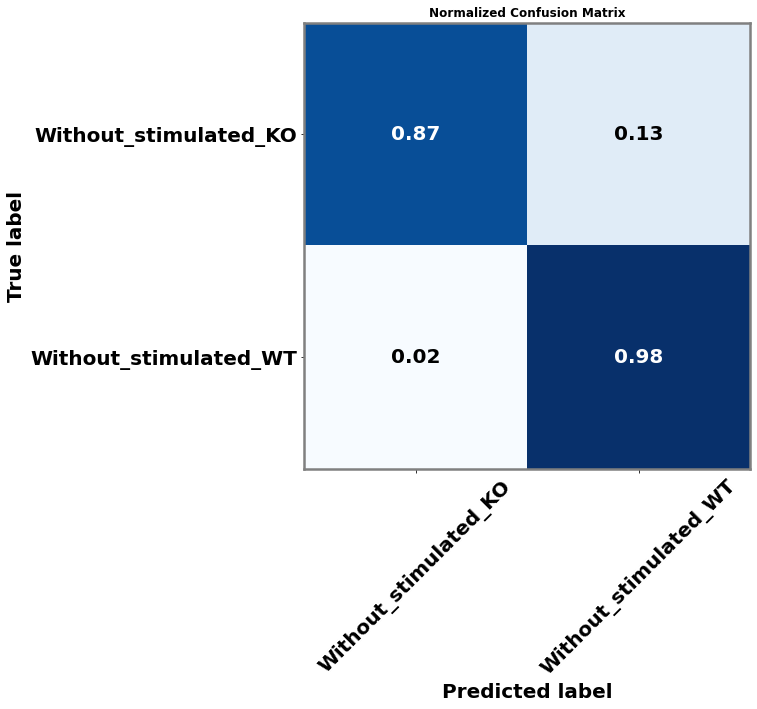

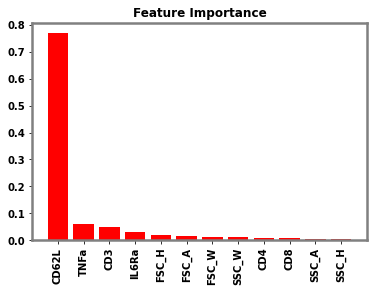

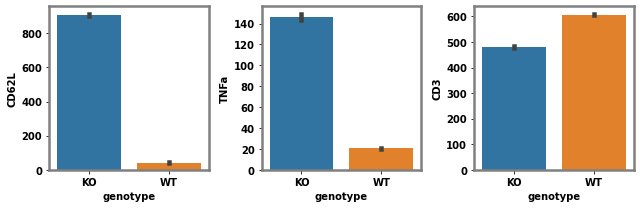

                       precision    recall  f1-score   support

Without_stimulated_KO       0.97      0.87      0.91     15822
Without_stimulated_WT       0.91      0.98      0.94     20595

             accuracy                           0.93     36417
            macro avg       0.94      0.92      0.93     36417
         weighted avg       0.93      0.93      0.93     36417



In [37]:
xgb_clf_cd4_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_wo,3)

### CD4 GI

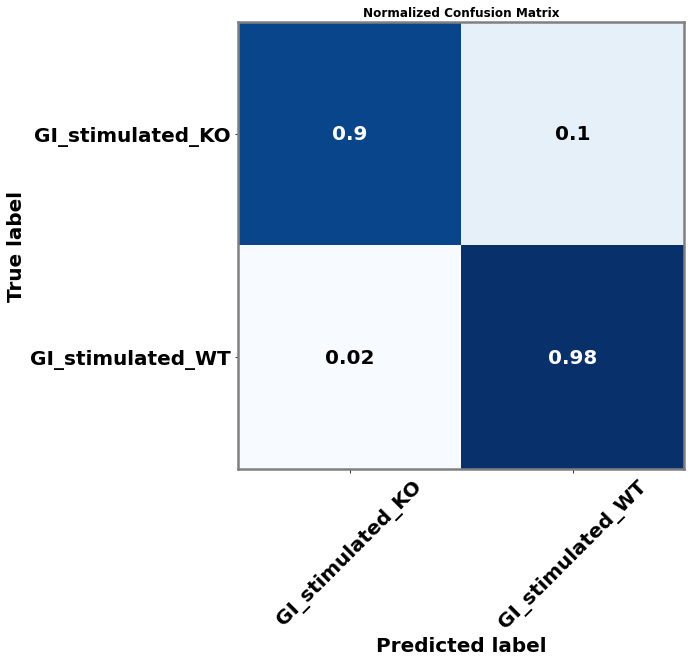

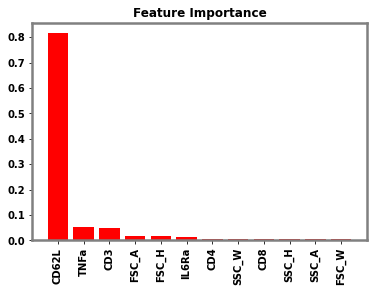

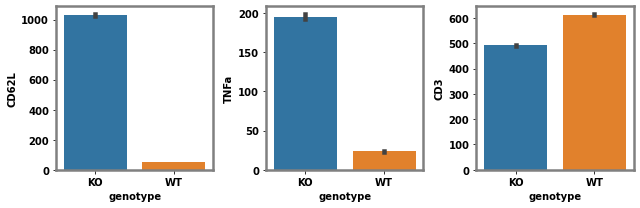

                  precision    recall  f1-score   support

GI_stimulated_KO       0.98      0.90      0.93     17071
GI_stimulated_WT       0.92      0.98      0.95     20457

        accuracy                           0.94     37528
       macro avg       0.95      0.94      0.94     37528
    weighted avg       0.94      0.94      0.94     37528



In [38]:
xgb_clf_cd4_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_gi,3)

### CD4 gw

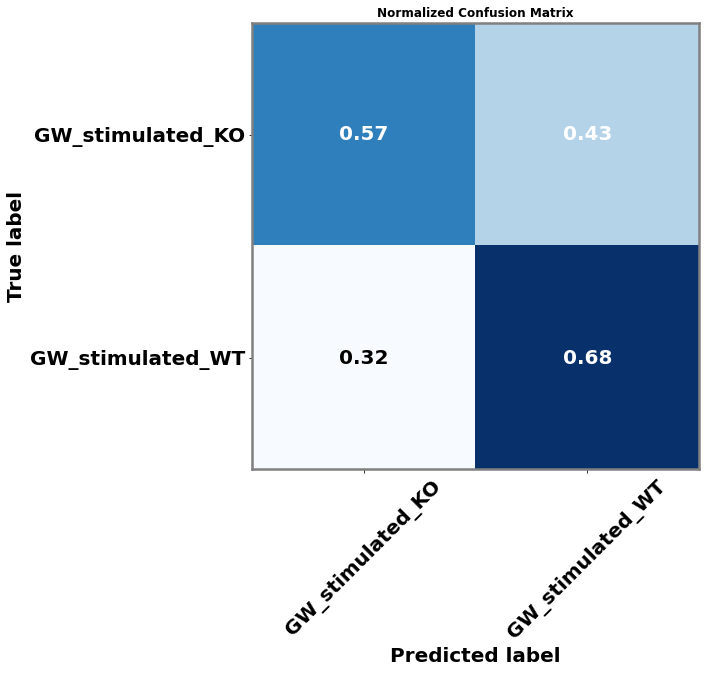

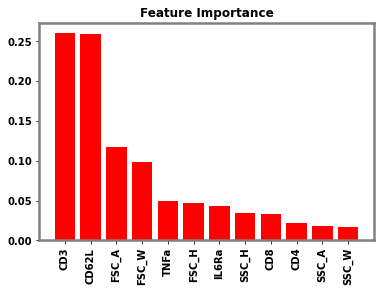

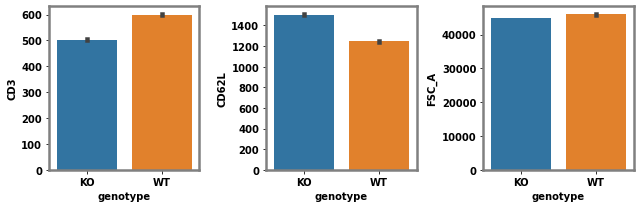

                  precision    recall  f1-score   support

GW_stimulated_KO       0.69      0.57      0.62     23705
GW_stimulated_WT       0.55      0.68      0.61     18629

        accuracy                           0.62     42334
       macro avg       0.62      0.62      0.62     42334
    weighted avg       0.63      0.62      0.62     42334



In [39]:
xgb_clf_cd4_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_gw,3)

## rest

### rest without

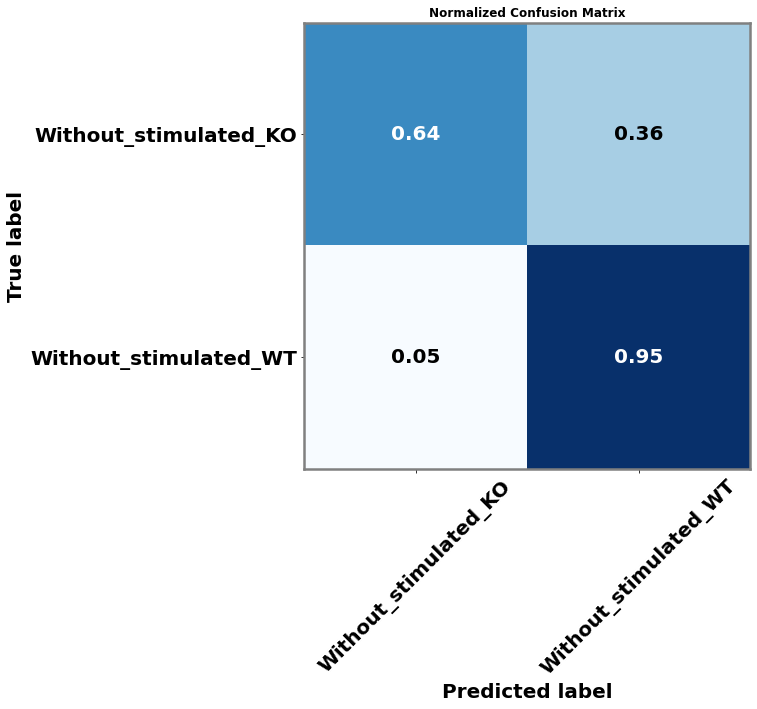

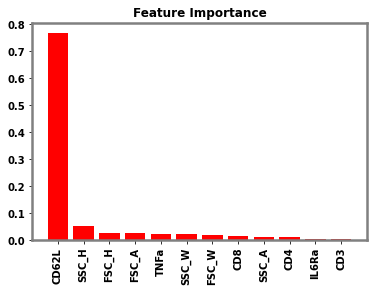

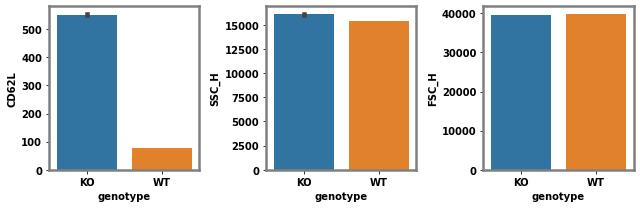

                       precision    recall  f1-score   support

Without_stimulated_KO       0.88      0.64      0.74     49002
Without_stimulated_WT       0.81      0.95      0.87     80942

             accuracy                           0.83    129944
            macro avg       0.85      0.79      0.81    129944
         weighted avg       0.84      0.83      0.82    129944



In [40]:
xgb_clf_rest_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_wo,3)

### rest GI

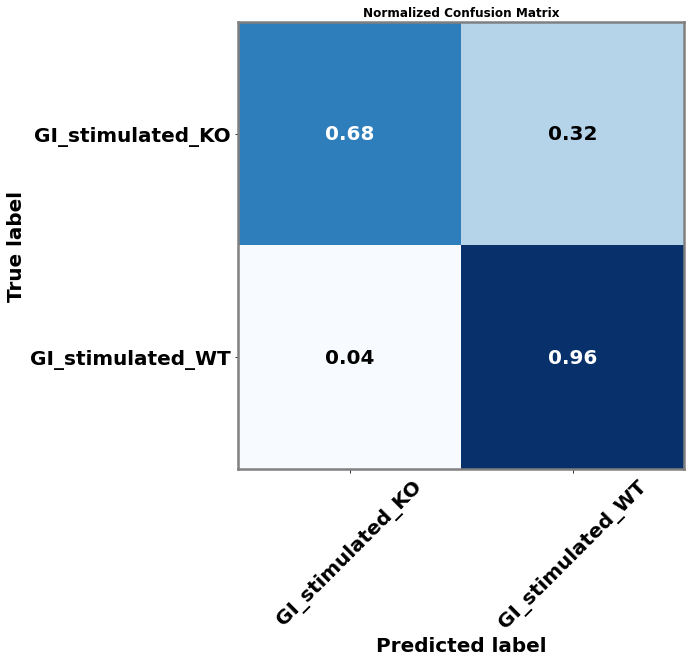

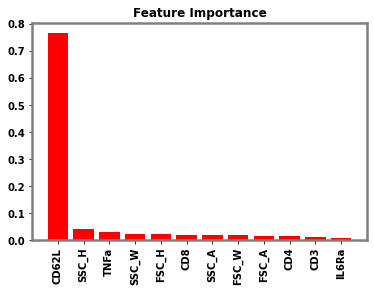

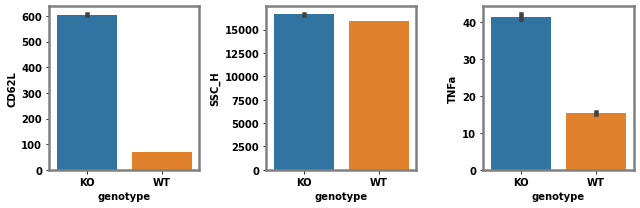

                  precision    recall  f1-score   support

GI_stimulated_KO       0.96      0.68      0.80     94749
GI_stimulated_WT       0.69      0.96      0.80     71134

        accuracy                           0.80    165883
       macro avg       0.82      0.82      0.80    165883
    weighted avg       0.84      0.80      0.80    165883



In [41]:
xgb_clf_rest_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_gi,3)

### rest gw

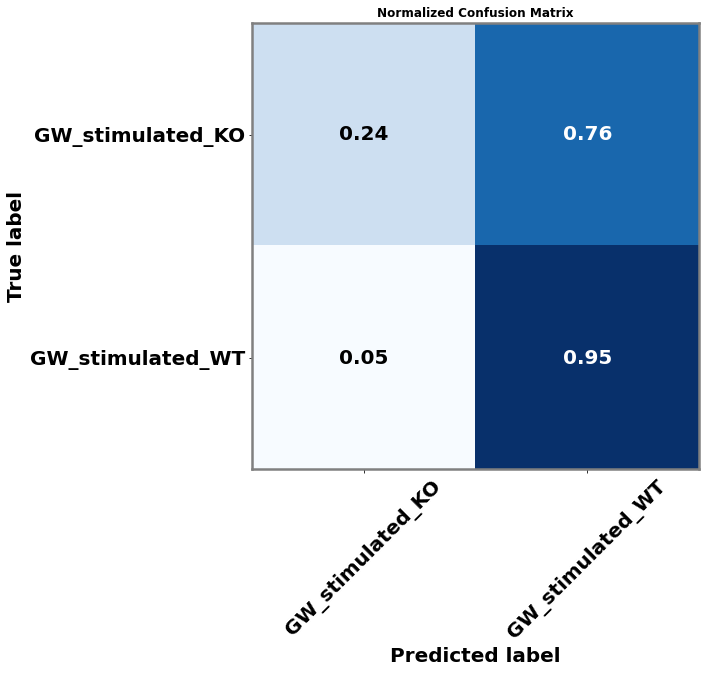

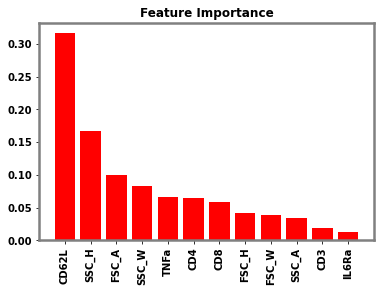

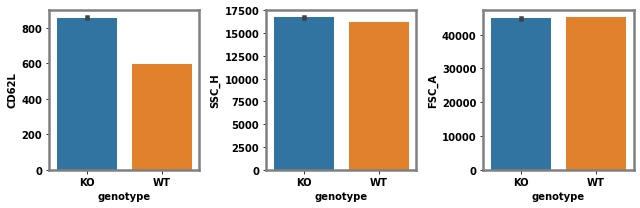

                  precision    recall  f1-score   support

GW_stimulated_KO       0.81      0.24      0.37     72005
GW_stimulated_WT       0.55      0.95      0.70     72191

        accuracy                           0.59    144196
       macro avg       0.68      0.59      0.53    144196
    weighted avg       0.68      0.59      0.53    144196



In [42]:
xgb_clf_rest_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_gw,3)

# test

In [43]:
df_test_wo = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")]

In [44]:
def pop_model2(df,gt,pop,x_list, y_label, model, top=3):
    konr = df[df["genotype"]==gt[0]]["mousenr"].unique()
    wtnr = df[df["genotype"]==gt[1]]["mousenr"].unique()
    
    df_train = df[df["mousenr"].isin(konr[:-1])|df["mousenr"].isin(wtnr[:-1])]
    df_val = df[df["mousenr"].isin(konr[-1:])|df["mousenr"].isin(wtnr[-1:])]
  
    df_pop_train = df_train.copy()
    df_pop_val = df_val.copy()
    
    X_train = df_pop_train[x_list]
    y_train = df_pop_train[y_label]
    X_val = df_pop_val[x_list]
    y_val = df_pop_val[y_label]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    ax1=skplt.metrics.plot_confusion_matrix(y_val, y_pred, figsize=(10,10), text_fontsize=20, normalize = True)
    xlabels = ax1.get_xticklabels()
    ax1.set_xticklabels(xlabels,rotation=45)
    ax1.images[-1].colorbar.remove()
    
    skplt.estimators.plot_feature_importances(model, feature_names=x_list,max_num_features=20)
    plt.xticks(rotation=90)
    plt.show();
    
    fimp = sorted([(elm,numeric_features[idx]) for idx,elm in enumerate(model.feature_importances_)],reverse=True)
    
    fig, axs = plt.subplots(1,top,figsize=(9,3))
    for i in range(top):
        sns.barplot(x = df_pop_train.genotype.astype("object"), y = df_pop_train[fimp[i][1]], ax = axs[i] )
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_val, y_pred))

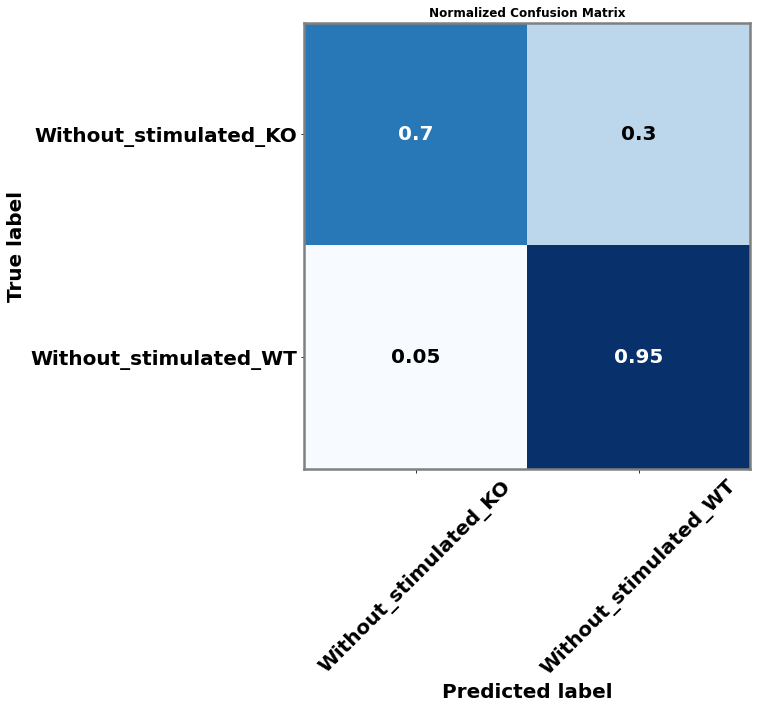

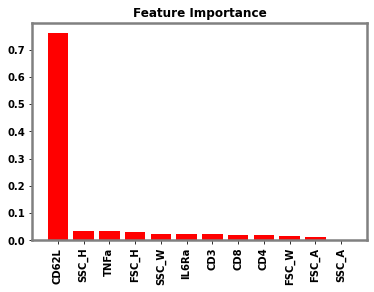

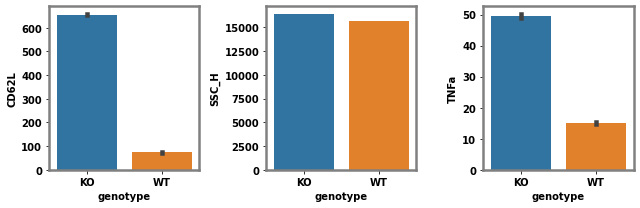

                       precision    recall  f1-score   support

Without_stimulated_KO       0.91      0.70      0.79     78035
Without_stimulated_WT       0.82      0.95      0.88    114193

             accuracy                           0.85    192228
            macro avg       0.87      0.83      0.84    192228
         weighted avg       0.86      0.85      0.85    192228



In [45]:
xgb_clf_rest_test = XGBClassifier(n_jobs = -1,random_state=42)
pop_model2(df_test_wo,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_test,3)